<a href="https://colab.research.google.com/github/arpit190176/Pair-Trading-Strategy/blob/main/arpit_FAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the libraries

import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint   # use this library to find this out the p_value
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from functools import cmp_to_key
import datetime
import fix_yahoo_finance as yf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# predefined functions in this cell ,  no need to chagne them

def downloadStockData(tickers,start,end):
    """
        This function downloads the Close price of the stock and creates a dataframe from it
        Params:
            tickers : a list of ticker of various stocks
            start   : it is the start date of the data to be downloaded. It is a datetime in datetime format.
            end     : it is the end date of the data to be downloaded. It is a datetime in datetime format.

        Return:
            A dataframe with all the close for of each stock on each open market day
    """
    ticker_data = pdr.get_data_yahoo(tickers, start, end)['Close']
    return ticker_data

def zscore(series):
    return (series - series.mean()) / np.std(series)

def plot_ratios(ratios):
    """
        This function just plots the ratios plot 
        Params:
            ratio : a list of the the ration of two stock price 
    """
    ratios.plot()
    plt.axhline(ratios.mean(),color="yellow")
    plt.show()


In [ ]:
def findCointegrationValue(data,p_value_threshold=0.05):
    """
        This function find out the pairs of stock with p value less than a constant
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            p_value_threshold  : the threshold value for the p value of pairs of stocks. We consider a 2 stocks to be cointegrted only if the p value is less than this value

        Returns:
            p values of all the pairs , the list of all the pairs with p value less than the threshold 
    """
    n = data.shape[1]
    pMat = np.ones((n,n));
    keys = data.keys();
    pairs = []
    for i in range(n):
      for j in range(i+1,n):
        d1 = data[keys[i]]
        d2 = data[keys[j]]
        result = coint(d1,d2)
        
        pvalue = result[1]
        score = result[0]
        pMat[i,j]=pvalue
        if(pvalue < p_value_threshold):
          pairs.append(((i,j),pvalue))
        
    return pMat,pairs

In [ ]:
def compare(x,y):
  return x[1]-y[1]

In [ ]:
def getBestKCointergratedStocks(data,k=10,p_value_threshold=0.05):
    """
        This functions find out the k pairs with the least p value and all of them should be less than the threshold  
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            k                  : the number of pairs to be found out
            p_value_threshold  : the threshold value for the p value of pairs of stocks. We consider a 2 stocks to be cointegrted only if the p value is less than this value

        Returns:
            the p value for all the pairs of stocks , the list k pairs with the least p value and their p values . If k such pairs doesn't exists return how many of them occur 
    """
    pMat, pairs = findCointegrationValue(data)
    tem=sorted(pairs,key=cmp_to_key(compare))
    if len(tem) < k:
      return pMat,tem
    return pMat,tem[0:k]
   

In [ ]:
def normalize(series):
  return series-series.min()/(series.max()-series.min())

In [ ]:
def distanceBetweenStocks(data1,data2,window_size):
    """
        This function takes list of two stocks and find the distance between the stocks 
        Params:
            data1: list of stock price of stock1
            data2: list of stock price of stock2
            window_size : the window size
        Returns:
            the distance between the lists

        Note:
            In this function do try to normalise the stock price and try out some variations in it.
    """
    data1 = normalize(data1)
    data2 = normalize(data2)
    distance=0 
    for i in range(len(data1)):
      distance += (data1[i] - data2[i])**2
    
    return distance


In [ ]:
def getBestKLessDistanceStocks(data,k=10):
    """
        This functions find out the k pairs with the least distance between them  
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            k                  : the number of pairs to be found out
            
        Returns:
            the distance between all the stock pairs, the list of k pairs with the least distance between them
    """
    pairs=[]
    keys=data.keys();
    n = data.shape[1]
    
    
    _distance=np.ones((n,n))
    for i in range(n):
      for j in range (i+1,n):
        
        d2=data[keys[j]]
        d1=data[keys[i]]
        ans=distanceBetweenStocks(d1,d2,200)
        _distance[i][j]=ans
        pairs.append((i,j))
    
    pairs.sort(key=cmp_to_key(compare))
    if(len(pairs)<k):
      return _distance,pairs
    return _distance,pairs[0:k]


    
    
    


In [ ]:
tickers = ['HD', 'DIS','MSFT', 'BA', 'MMM', 'PFE', 'NKE', 'JNJ', 'MCD', 'INTC', 'XOM', 'GS', 'JPM', 'AXP', 'V', 'IBM', 'UNH', 'PG', 'GE', 'KO', 'CSCO', 'CVX', 'CAT', 'MRK', 'WMT', 'VZ', 'RTX', 'TRV', 'AAPL', 'ADBE', 'EBAY', 'QCOM', 'HPQ', 'JNPR', 'AMD']
start = datetime.datetime(2013,1,1)
end = datetime.datetime(2021,1,1)
data = downloadStockData(tickers,start,end)

In [ ]:
data.head(5)

Symbols,HD,DIS,MSFT,BA,MMM,PFE,NKE,JNJ,MCD,INTC,XOM,GS,JPM,AXP,V,IBM,UNH,PG,GE,KO,CSCO,CVX,CAT,MRK,WMT,VZ,RTX,TRV,AAPL,ADBE,EBAY,QCOM,HPQ,JNPR,AMD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,63.480000,51.099998,27.620001,77.070000,94.779999,24.582542,25.920000,70.839996,90.120003,21.379999,88.709999,131.660004,44.660000,58.750000,38.845001,196.350006,54.540001,69.389999,20.519232,37.599998,20.340000,110.389999,93.500000,39.446564,69.239998,44.270000,52.863438,72.860001,19.608213,38.340000,22.554714,64.750000,6.821072,20.549999,2.53
2013-01-03,63.299999,51.209999,27.250000,77.470001,94.669998,24.525618,26.184999,70.739998,90.629997,21.320000,88.550003,130.940002,44.570000,59.000000,38.875000,195.270004,51.990002,68.949997,20.288462,37.599998,20.450001,109.919998,94.400002,40.391220,68.800003,44.060001,53.058529,73.419998,19.360714,37.750000,22.074917,64.449997,6.875568,20.170000,2.49
2013-01-04,63.180000,52.189999,26.740000,77.690002,95.370003,24.629980,26.440001,71.550003,89.849998,21.160000,88.959999,134.509995,45.360001,59.610001,39.192501,193.990005,52.090000,69.089996,20.384615,37.660000,20.480000,110.500000,94.919998,40.047710,69.059998,44.299999,53.480175,74.059998,18.821428,38.130001,22.213804,63.500000,6.875568,20.379999,2.59
2013-01-07,62.840000,50.970001,26.690001,76.129997,95.489998,24.648956,26.480000,71.400002,90.910004,21.250000,87.930000,134.259995,45.410000,59.860001,39.472500,193.139999,52.090000,68.620003,20.317308,37.299999,20.290001,109.750000,95.209999,40.190842,68.400002,44.689999,53.222153,73.059998,18.710714,37.939999,22.521044,64.010002,6.889192,20.150000,2.67
2013-01-08,63.220001,50.759998,26.549999,74.129997,95.500000,24.686907,26.200001,71.410004,90.940002,21.090000,88.480003,133.050003,45.500000,60.200001,39.840000,192.869995,51.400002,68.510002,20.096153,37.040001,20.309999,109.260002,94.000000,40.248093,68.589996,43.099998,52.580238,73.190002,18.761070,38.139999,22.171717,63.910000,6.989101,19.719999,2.67


In [ ]:
p_value_matrix,bestCointegrated = getBestKCointergratedStocks(data)
bestCointegrated

[((25, 29), 0.0015927567775401998),
 ((7, 16), 0.001967185941990895),
 ((15, 19), 0.0021739928266725824),
 ((19, 25), 0.002711770826849394),
 ((10, 28), 0.0027792248810815066),
 ((0, 16), 0.003457179066533632),
 ((5, 15), 0.003809370812433187),
 ((5, 20), 0.005048206254305592),
 ((15, 16), 0.005410531699856885),
 ((10, 34), 0.006243612201103763)]

In [ ]:
keys = data.keys()


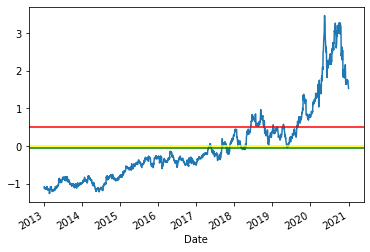

In [ ]:
ratios=data['HD'].copy()/data['TRV'].copy() 
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="yellow")
plt.axhline(0.5, color="red")
plt.axhline(-0.05, color="green")
plt.show()

The pair of stocks showing the lowest P-value is plotted below:-

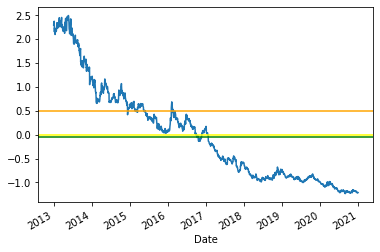

VZ ADBE


In [ ]:
d1=keys[bestCointegrated[0][0][0]]
d2=keys[bestCointegrated[0][0][1]]
ratios = data[d1]/data[d2]
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="yellow")
plt.axhline(0.5, color="orange")
plt.axhline(-0.05, color="green")
plt.show()
print(d1,d2)

# Reaons why those 2 stocks are similar. (Explain for any 2 stocks in this text cell)


The stocks of Verizon(VZ) and Adobe(ADB) show the lowest p value. Hence, they are strongly cointegrated.
Verizon and Adobe have been in a strategic partnership for a number of years. They invest in each other to move the strategy forward. So it is expected that the stocks of these companies will show a fair amount of cointegration.
Also Verizon's Wireless online media store has been built on Adobe's Flash playform including Adobe digital enterprise platform.
